In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [273]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [45]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *

In [15]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [17]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_lighting=0.15, max_zoom=1.5, max_warp=0.)

In [18]:
np.random.seed(42)

In [19]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [20]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

In [21]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

## Split data into train val 

In [25]:
split_handler = SplitByPatient(hem_patients, all_patints)

### Split by patient 

In [168]:
hem_train, all_train, hem_val, all_val = split_handler.split_by_patients(test_size=0.1)

### Split by regex

In [26]:
train_regex = re.compile(r'(fold_0|fold_1)')
val_regex = re.compile(r'(fold_2)')

hem_train, all_train, hem_val, all_val = split_handler.split_by_regex(train_regex, val_regex)

In [27]:
print('Train Total: {0}'.format(len(hem_train)+len(all_train)))
print('Val Total: {0}'.format(len(hem_val)+len(all_val)))
print("")
print('Hem train: {}'.format(len(hem_train)))
print('All train: {}'.format(len(all_train)))
print('Hem val: {}'.format(len(hem_val)))
print('All val: {}'.format(len(all_val)))

Train Total: 7108
Val Total: 3517

Hem train: 2293
All train: 4815
Hem val: 1060
All val: 2457


In [28]:
pat = re.compile(r'^.*(hem|all).bmp$')

def get_label(fn):
    return pat.search(str(fn)).group(1)

### Use complete image

In [149]:
train = ImageItemList(hem_train+all_train)
valid = ImageItemList(hem_val + all_val)

### Use just the cell

In [185]:
class ImageItemListCell(ImageItemList):

    def open(self, fn):
        #image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)
        image = np.asarray(PIL.Image.open(fn).convert(self.convert_mode))
        
        rows = np.any(image, axis=1)
        cols = np.any(image, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        sub_image = image[rmin:rmax, cmin:cmax] / 255.

        return Image(pil2tensor(sub_image, np.float32))
    
valid = ImageItemListCell(hem_val+all_val)
train = ImageItemListCell(hem_train+all_train)

In [186]:
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_label)

#### Data augmentation

In [152]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [214]:
def _cutout(img, n_holes:int = 5, length:float = 0.05)->Tensor:
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (float): The length (in percent of the image size) of each square patch.
    """
    h = img.size(1)
    w = img.size(2)
    patch_width = int(w * length)
    path_height = int(h * length)

    mask = np.ones((h, w), np.float32)

    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - path_height // 2, 0, h)
        y2 = np.clip(y + path_height // 2, 0, h)
        x1 = np.clip(x - patch_width // 2, 0, w)
        x2 = np.clip(x + patch_width // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    return img * mask
cutout = TfmLighting(_cutout)

In [257]:
xtra_tfms=[squish(scale=0.66), cutout(n_holes=5, length=0.2)]
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0.15, 
                      max_zoom=1.5, 
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

In [234]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.5)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.425, 0.575)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.85, 1.1764705882352942)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (squish), kwargs={'scale': 0.66}, p=1.

#### Create dataset 

In [74]:
channel_mean = [0.2924981831505949, 0.13054762344214763, 0.3270776675890471]
channel_std = [0.05985960989724747, 0.043419036762350025, 0.050335686496007025]

In [265]:
size = 64
bs = 128

In [268]:
def get_data(bs, size):
    data  = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, 
                                      ds_tfms=tfms, padding_mode='zeros',
                                      resize_method=ResizeMethod.PAD)
    data = data.normalize()
    #data = data.normalize((channel_mean, channel_std))
    return data
    

In [269]:
data = get_data(bs, size)

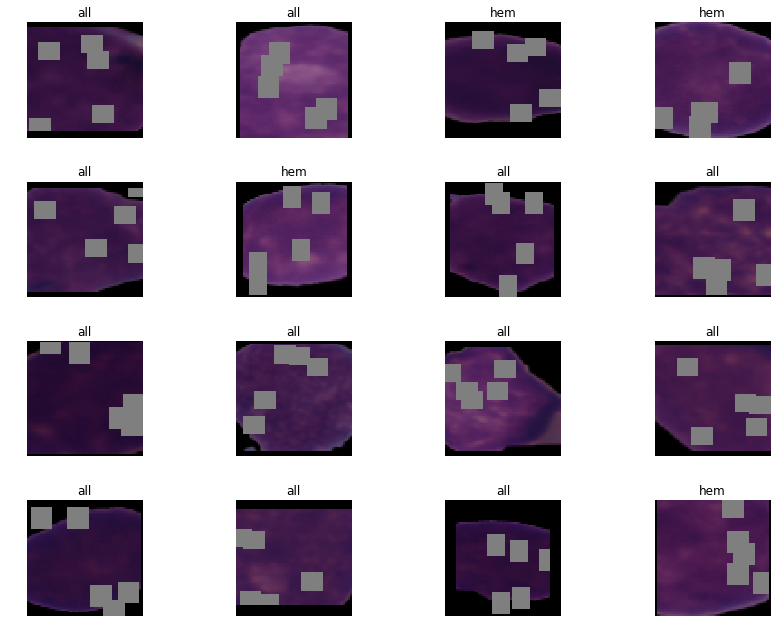

In [270]:
data.show_batch(rows=4, figsize=(12,9))

### Start training  64

In [302]:
experiment_name = 'rn18'

In [331]:
size = 64
bs = 128

In [332]:
learn = create_cnn(get_data(bs, size), models.resnet18, 
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.5, gamma=1)
                   #ps=0.75,
                   wd=0.01,
                   callback_fns=[ShowGraph, partial(SaveModelCallback, monitor="mcc", mode='max', name='stage1-{}-{}'.format(experiment_name, size))],
                  ).mixup().to_fp16()

In [333]:
learn.callback_fns

[fastai.basic_train.Recorder,
 fastai.train.ShowGraph,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, monitor='mcc', mode='max', name='stage1-rn18-64'),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


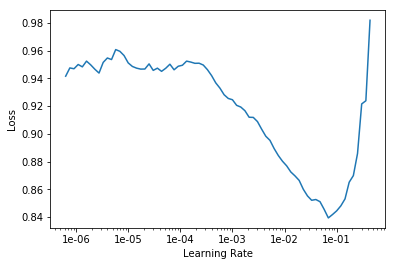

In [320]:
learn.lr_find()
learn.recorder.plot()

In [334]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.743999,0.634959,0.299972,0.577960,0.057446
2,0.654950,0.624649,0.322434,0.683330,0.266439
3,0.602180,0.615878,0.278931,0.629832,0.219180
4,0.572835,0.538446,0.243674,0.709351,0.354376
5,0.556587,0.547260,0.253341,0.680411,0.330264


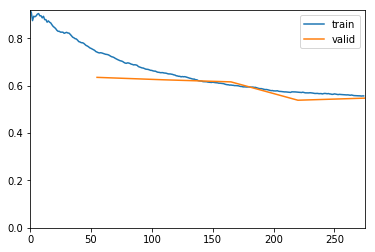

In [335]:
learn.fit_one_cycle(5, lr) #, pct_start=0.8

##### And fine-tune the whole model

In [336]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


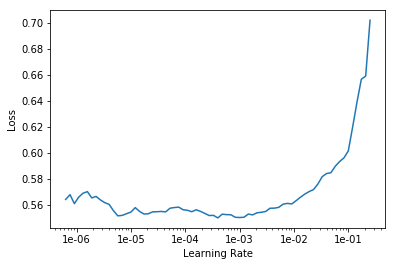

In [337]:
learn.lr_find()
learn.recorder.plot()

In [338]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.537012,0.539279,0.245948,0.700942,0.349101
2,0.540080,0.544615,0.241115,0.714272,0.362929
3,0.536074,0.519158,0.229173,0.746336,0.403617
4,0.534411,0.506382,0.220927,0.755110,0.427966
5,0.524641,0.507823,0.220643,0.756474,0.429246
6,0.523079,0.500626,0.218652,0.752742,0.434457
7,0.520633,0.499985,0.220358,0.751595,0.429035
8,0.517601,0.504782,0.221780,0.742324,0.427415
9,0.517168,0.501437,0.217515,0.751635,0.438850
10,0.517931,0.498753,0.217231,0.752041,0.439727


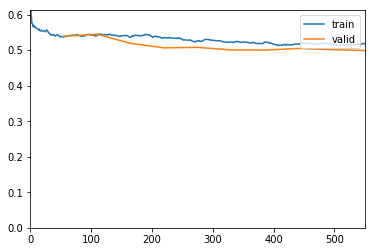

In [339]:
learn.fit_one_cycle(10, slice(1e-5,lr/5))

### Start training  128

In [313]:
size = 128
bs = 128
learn.freeze()

In [314]:
learn.data = get_data(bs, size)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


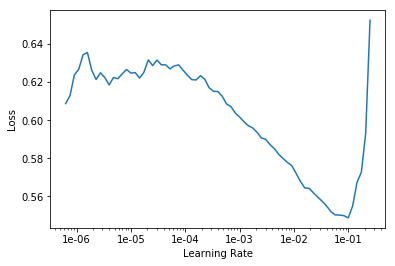

In [315]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.497305,0.435382,0.171453,0.806361,0.582048
2,0.459138,0.478959,0.207848,0.796502,0.534197
3,0.450074,0.600547,0.230594,0.715548,0.417401
4,0.442091,0.543880,0.292579,0.719014,0.413131
5,0.439296,0.396053,0.162070,0.819025,0.606172
6,0.430459,0.415088,0.165198,0.815588,0.596560
7,0.421793,0.404819,0.173728,0.815001,0.564275
8,0.413679,0.413097,0.161217,0.824436,0.600894
9,0.408401,0.434929,0.170600,0.806528,0.586601
10,0.405049,0.409126,0.157236,0.829575,0.611221


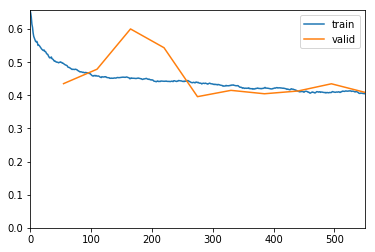

In [316]:
lr = 1e-2
learn.fit_one_cycle(10, lr)

##### And fine-tune the whole model

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

In [ ]:
learn.fit_one_cycle(5, slice(1e-5,lr/5))

### Start training  256

In [ ]:
size = 256
bs = 128
learn.freeze()

In [ ]:
learn.data = get_data(bs, size)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))

In [ ]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

##### And fine-tune the whole model

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

In [ ]:
learn.fit_one_cycle(5, slice(1e-5,lr/5))

### Start training  450

In [ ]:
size = 450
bs = 128
learn.freeze()

In [ ]:
learn.data = get_data(bs, size)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))

In [ ]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

##### And fine-tune the whole model

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

In [ ]:
learn.fit_one_cycle(5, slice(1e-5,lr/5))

## Results

In [84]:
learn.loss_func = data.loss_func
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

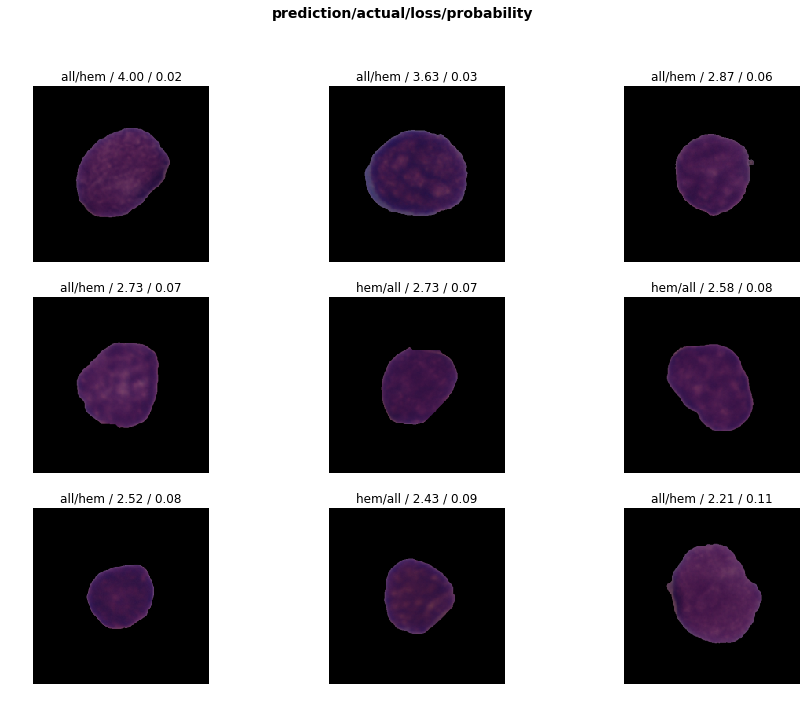

In [85]:
interp.plot_top_losses(9, figsize=(15,11))

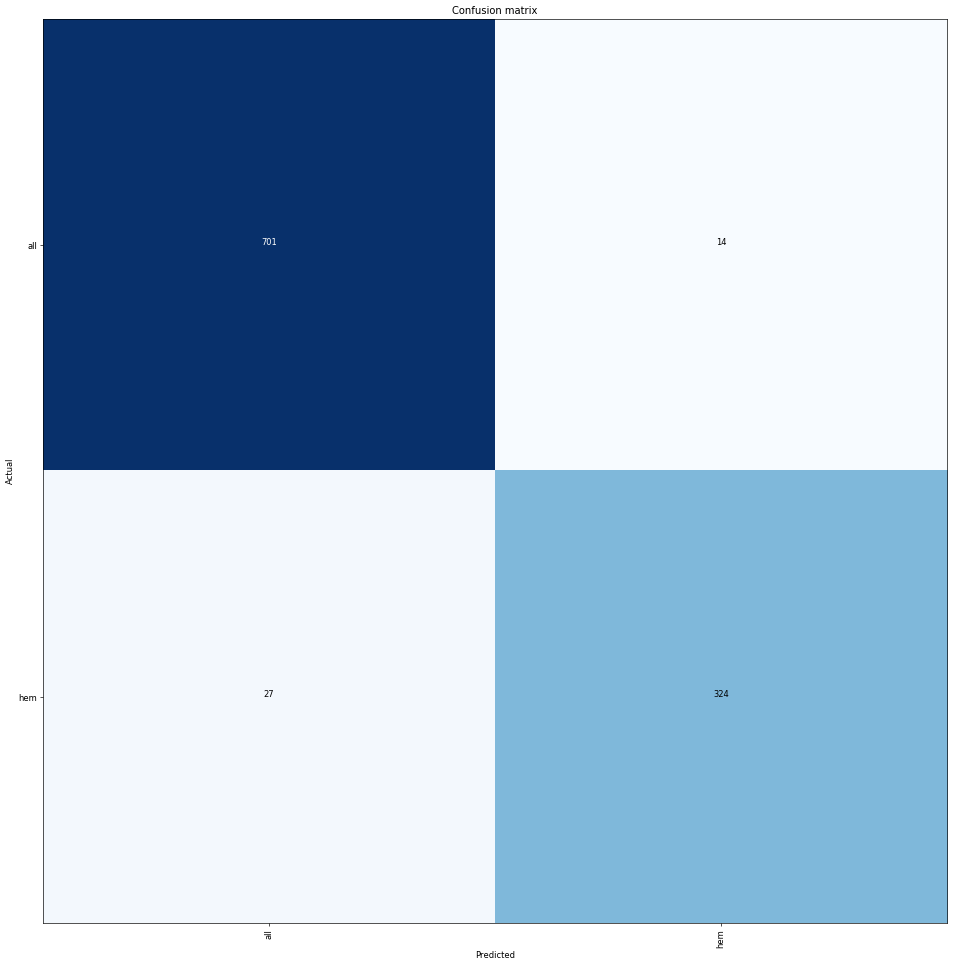

In [86]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

In [87]:
int(interp.confusion_matrix().flatten()[[1, 2]].sum())

41